In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [2]:
data = pd.read_csv("./data.csv")
ports = data["Source Port"].unique()
ports = ports[ports !=1883]



In [3]:
devices = {}
#  : devices será um dicionario que irá ter uma chave referente ao device e o valor será um dataframe referente aos respectivos devices 
for port in ports:  
  array_publish = data.loc[data["Source Port"] == port].dropna(subset=['Message Identifier'])
  array_publish_ack = data.loc[data["Destination Port"] == port].dropna(subset=['Message Identifier'])
  device = {"publish":array_publish, "publish_ack" : array_publish_ack}
  devices[port] = device

In [4]:
data = {}
for port in ports:
    RTT = pd.DataFrame(columns=["Time_publish", "Time_ack"])
    for index, row in devices[port]["publish"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_publish"] = time_publish 

    for index, row in devices[port]["publish_ack"].iterrows():
        id = int(row["Message Identifier"])
        time_publish = row["Time"]
        RTT.loc[id, "Time_ack"] = time_publish
    RTT.loc[id, "Time_ack"] = time_publish
    RTT["RTT"]  =(RTT["Time_ack"] - RTT["Time_publish"] )* 1000
    data[port] = RTT


In [5]:
data[37953].head()

,Time_publish,Time_ack,RTT
1,26.023436,26.02622,2.783157
2,27.028577,27.031372,2.794709
3,28.03388,28.036672,2.791512
4,29.038713,29.041347,2.633264
5,30.042765,30.045957,3.192541


## Medidas de Tendência Central Por Device

In [6]:
i=1
data_mean = []
data_median = []
data_std = []
data_min = []
data_max = []

for port in ports:
  data_mean.append(data[port]["RTT"].mean())
  data_median.append(data[port]["RTT"].mean())
  data_std.append(data[port]["RTT"].mean())
  data_min.append(data[port]["RTT"].mean())
  data_max.append(data[port]["RTT"].mean())

  print("(Device-{})Mean Round Trip Time = {}".format(i ,data[port]["RTT"].mean()))
  print("(Device-{})Median Round Trip Time = {}".format(i ,data[port]["RTT"].median()))
  print("(Device-{})Standard deviation  Round Trip Time = {}".format(i ,data[port]["RTT"].std()))
  print("(Device-{})Min Round Trip Time = {}".format(i ,data[port]["RTT"].min()))
  print("(Device-{})Max Round Trip Time = {}".format(i ,data[port]["RTT"].max()))
  print("---------------------------------------------------------------")

  i+=1

(Device-1)Mean Round Trip Time = 2.794579920265673
(Device-1)Median Round Trip Time = 2.6867750000008073
(Device-1)Standard deviation  Round Trip Time = 0.6409882996918244
(Device-1)Min Round Trip Time = 2.37513999991279
(Device-1)Max Round Trip Time = 12.155039000049328
---------------------------------------------------------------


## Medidas de Tendência Central Geral

In [7]:
from statistics import mean 

print("Mean Round Trip Time = {}".format(mean(data_mean)))
print("Median Round Trip Time = {}".format(mean(data_median)))
print("Standard deviation  Round Trip Time = {}".format(mean(data_std)))
print("Min Round Trip Time = {}".format(mean(data_min)))
print("Max Round Trip Time = {}".format(mean(data_max)))


Mean Round Trip Time = 2.794579920265673
Median Round Trip Time = 2.794579920265673
Standard deviation  Round Trip Time = 2.794579920265673
Min Round Trip Time = 2.794579920265673
Max Round Trip Time = 2.794579920265673


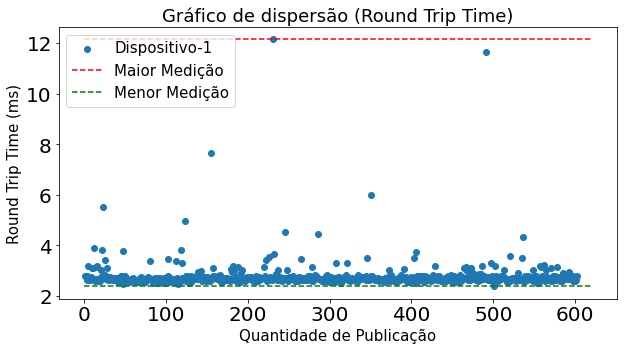

In [39]:
import matplotlib 
# matplotlib.rc('xtick', labelsize=20) 
# matplotlib.rc('ytick', labelsize=20) 
# matplotlib.rcParams.update({'font.size': 15})


i=1
fig, ax = plt.subplots(figsize=(10,5),dpi=72)
for port in ports:
  ax.scatter(data[port]["RTT"].index,data[port]["RTT"], label='Dispositivo-{}'.format(i))
  ax.set_ylabel('Round Trip Time (ms)')
  ax.set_xlabel('Quantidade de Publicação')
  ax.set_title('Gráfico de dispersão (Round Trip Time)')
  ax.hlines(data[port]["RTT"].max(),  xmin=0, xmax=620, colors="red", linestyles="dashed", label="Maior Medição")
  ax.hlines(data[port]["RTT"].min(),  xmin=0, xmax=620, colors="green", linestyles="dashed", label="Menor Medição")
  ax.legend()

  i+=1


# <font color=green>CÁLCULO DO TAMANHO DA AMOSTRA</font>
***
## <font color=green>Variáveis quantitativas e população infinita</font>
***
## Nívéis de confiança e significância 
O **nível de confiança** ($1 - \alpha$) representa a probabilidade de acerto da estimativa. De forma complementar o **nível de significância** ($\alpha$) expressa a probabilidade de erro da estimativa.

O **nível de confiança** representa o grau de confiabilidade do resultado da estimativa estar dentro de determinado intervalo. Quando fixamos em uma pesquisa um **nível de confiança** de 95%, por exemplo, estamos assumindo que existe uma probabilidade de 95% dos resultados da pesquisa representarem bem a realidade, ou seja, estarem corretos.

O **nível de confiança** de uma estimativa pode ser obtido a partir da área sob a curva normal como ilustrado na figura abaixo.
![alt text](https://caelum-online-public.s3.amazonaws.com/1178-estatistica-parte2/01/img007.png)
Em nosso trabalho iremos utilizar um nivel de confiança de 95%, logo abaixo iremos calcular o Z.

Esta variável $Z$ representa o afastamento em desvios padrões de um valor da variável original em relação à média.

In [9]:
nivel_de_significancia = 0.05

In [10]:
nivel_de_confiança = 1 - nivel_de_significancia
nivel_de_confiança

0.95

In [11]:
#Calculando o z com scipy
z = scipy.stats.norm.ppf(0.975)
z

1.959963984540054

Com nosso z calculado podemos seguir adiante

### $$z = 1.959963984540054 $$

Abaixo segue algumas formulas que iremos utilizar para calcular o numero de amostra



## $$n = \left(z\frac{s}{e}\right)^2$$


$$e = \left(e *  \right)^2$$



Onde:

$z$ = variável normal padronizada

$s$ = desvio padrão amostral

$e$ = erro inferencial


### Calculando a desvio padrão $s$

In [12]:

data[ports[0]]["RTT"]

1      2.783157
2      2.794709
3      2.791512
4      2.633264
5      3.192541
         ...   
598    2.775105
599    2.614881
600    2.577169
601    2.625912
602    2.772189
Name: RTT, Length: 602, dtype: object

In [13]:
desvio_padrao_amostral = data[37953]["RTT"].std()
desvio_padrao_amostral

0.6409882996918244

### Calculando o Erro

In [14]:
media = RTT["RTT"].mean()
e = 0.05 * media
e

0.13972899601328367

### Calculando o tamanho da nossa amostra

In [15]:
n = (z * (desvio_padrao_amostral/e))**2
n

80.83944240619886